In [2]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [3]:
### Defining parameters and hyperparameters of the model

n_kernels=100 # Number of kernels in convolutional network
n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.3 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [4]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [5]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [6]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [7]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [8]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [9]:
aa = aa / np.max(alpha)

In [10]:
aa.shape

(144, 1)

In [11]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [12]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [13]:
hh = hh / np.max(h)

In [14]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [15]:
baseline_coord = data.iloc[:,:].values

In [16]:
standard_coord = baseline_coord.reshape((1, -1))

In [17]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [18]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [19]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [20]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [21]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [22]:
# Reshape the coordinates, in order to apply convolutional operation
x = total_coords.reshape((16*9, 2, 55, 1))

In [23]:
# Input of parameters
# These variables are put into the network after convolution and flattening
x_para = np.hstack((aa, hh, bb))

In [24]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [25]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [26]:
target_c3 = target_df.iloc[:,3].values # Cd values
target_c4 = target_df.iloc[:,4].values# Cl values

In [27]:
y = np.hstack((target_c3.reshape((-1,1)), target_c4.reshape((-1,1))))

In [28]:
y.shape

(144, 2)

In [29]:
x_para_train, x_para_test, x_train, x_test, y_train, y_test = train_test_split(x_para, x, y, test_size=test_rate, random_state=1)

In [30]:
os.chdir('D:\\TrainedModels\\20221119')
model = tf.keras.models.load_model('20221119steadyValidation_AeroCNN_I_test0.3_128units_normalized.h5')

test_results = model.evaluate([x_test, x_para_test], y_test)
decoded_train = model.predict([x_train, x_para_train])
decoded_test = model.predict([x_test, x_para_test])
error_train_abs = np.abs(decoded_train - y_train)
error_test_abs = np.abs(decoded_test - y_test)

2/2 [==============================] - 0s 2ms/step


In [31]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221120AeroCNN_I_revised\\test"+str(test_rate)
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

In [32]:
error_train_abs = np.abs(decoded_train - y_train)

In [33]:
error_test_abs = np.abs(decoded_test - y_test)

In [34]:
os.chdir(storage_dir)

In [35]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.0024997180656904975


In [36]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.01862098915435186


In [37]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,0] - y_train[:,0])**2) / np.sum(y_train[:,0]**2))
print(l2_error_Cd_train)

0.02917490533445455


In [38]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,1] - y_train[:,1])**2) / np.sum(y_train[:,1]**2))
print(l2_error_Cl_train)

0.002249553590521545


In [39]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,0] - y_test[:,0])**2) / np.sum(y_test[:,0]**2))
print(l2_error_Cd_test)

0.04037054915133273


In [40]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,1] - y_test[:,1])**2) / np.sum(y_test[:,1]**2))
print(l2_error_Cl_test)

0.018583197372633063


In [41]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [42]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

In [43]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i][0] - y_train[i][0])**2) / np.sum(y_train[i][0]**2))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [44]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / np.sum(y_train[i][1]**2))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [45]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / np.sum(y_test[i][0]**2))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [46]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / np.sum(y_test[i][1]**2))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

In [47]:
index_train = np.unique(np.where(np.isin(y, y_train)))
index_test = np.unique(np.where(np.isin(y, y_test)))
aa = aa*np.max(alpha)

In [48]:
predicted = model.predict([x,x_para])

5/5 [==============================] - 0s 13ms/step


In [54]:
np.sqrt(np.sum((predicted - y)**2) / np.sum(y**2))

0.009750504070316393

In [55]:
np.sqrt(np.sum((predicted[:,0] - y[:,0])**2) / np.sum(y[:,0]**2))

0.031924527842616915

In [56]:
np.sqrt(np.sum((predicted[:,1] - y[:,1])**2) / np.sum(y[:,1]**2))

0.00968750327157434

1/1 [==============================] - 0s 15ms/step
NACA0018 airfoil without Gurney flap
L2 error of Cd: 0.0239, L2 error of Cl: 0.0044


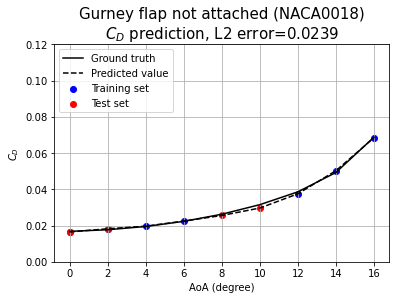

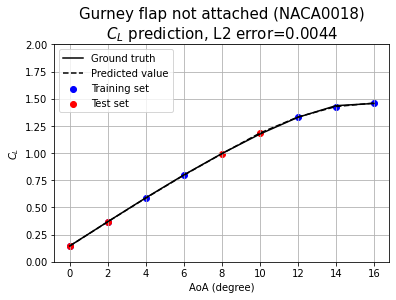

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0263, L2 error of Cl: 0.0068


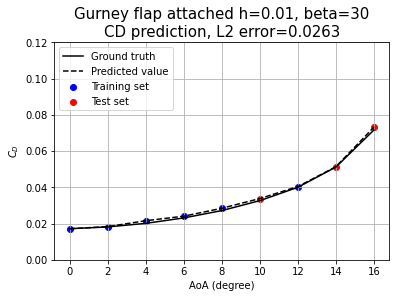

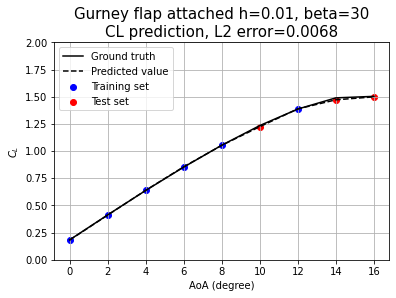

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0319, L2 error of Cl: 0.0039


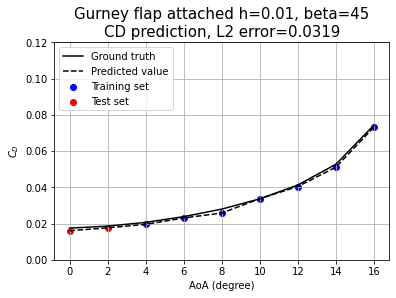

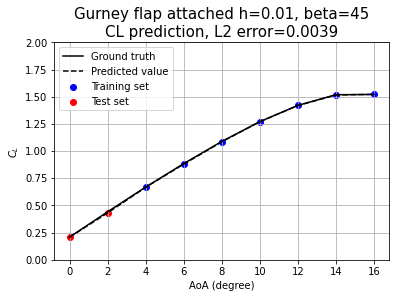

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0370, L2 error of Cl: 0.0090


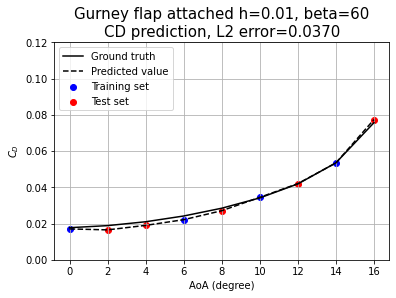

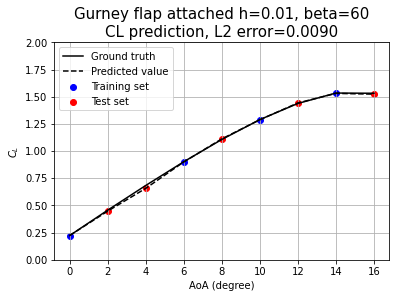

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0376, L2 error of Cl: 0.0151


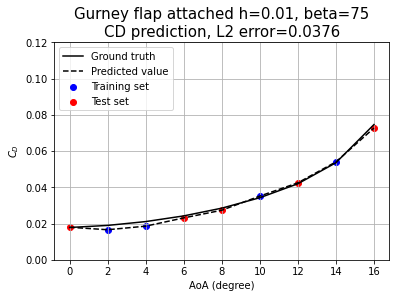

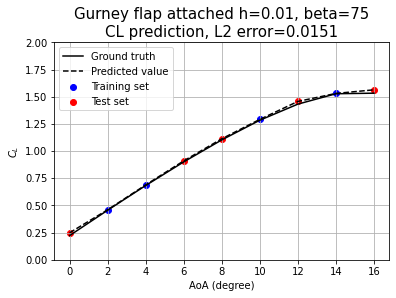

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0458, L2 error of Cl: 0.0094


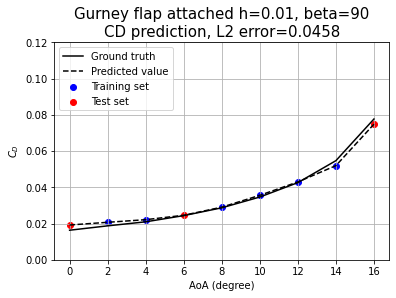

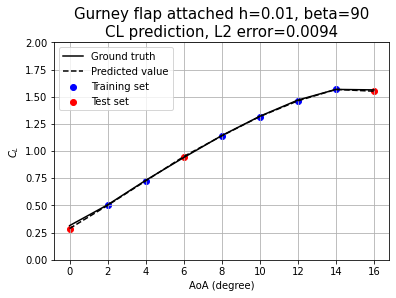

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0322, L2 error of Cl: 0.0018


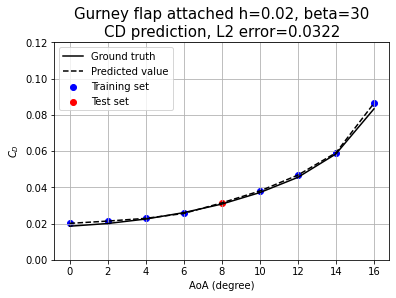

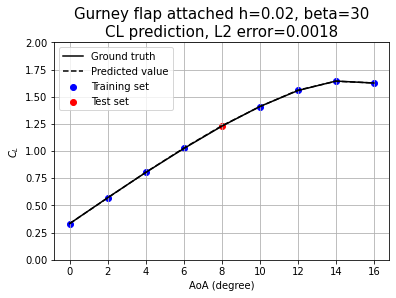

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0251, L2 error of Cl: 0.0028


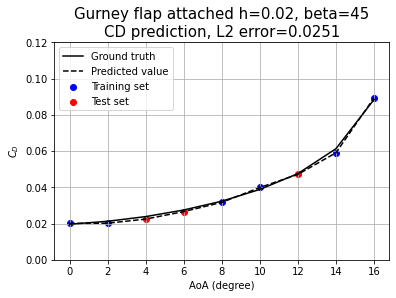

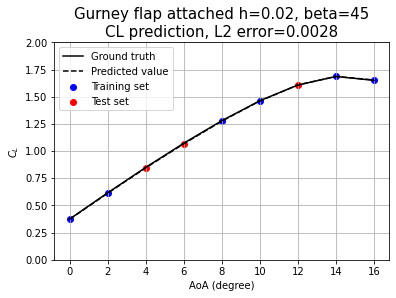

1/1 [==============================] - 0s 17ms/step
L2 error of Cd: 0.0175, L2 error of Cl: 0.0087


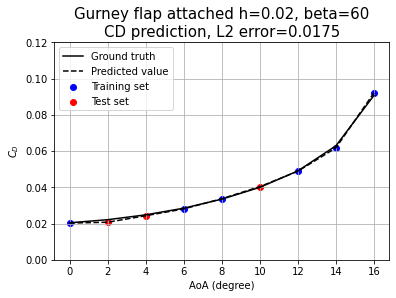

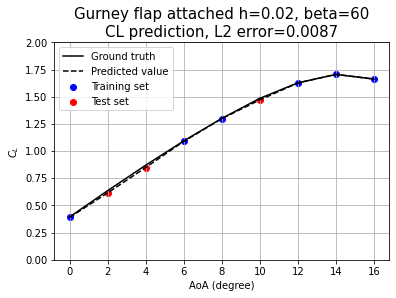

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0274, L2 error of Cl: 0.0073


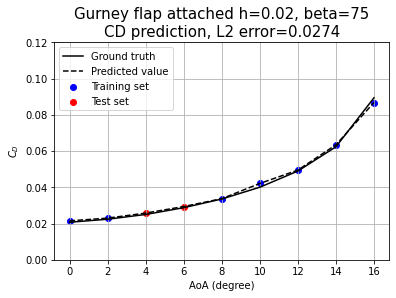

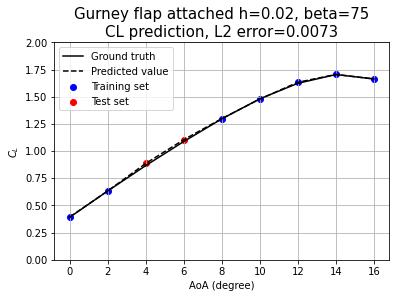

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0407, L2 error of Cl: 0.0060


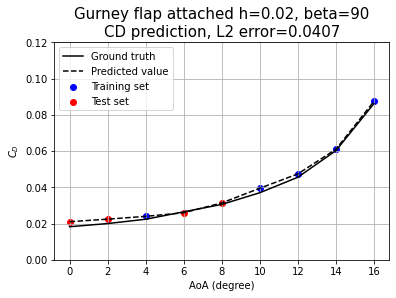

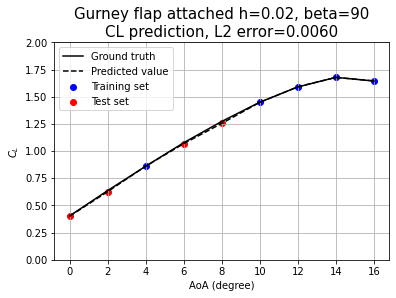

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0256, L2 error of Cl: 0.0051


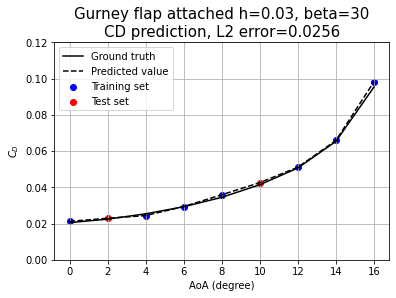

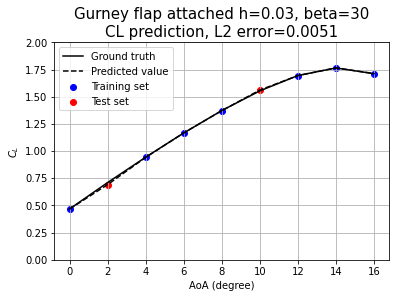

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0282, L2 error of Cl: 0.0055


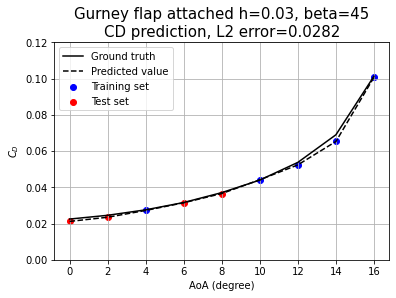

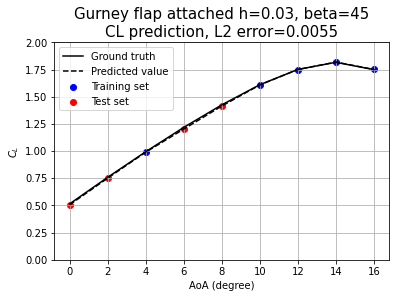

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0236, L2 error of Cl: 0.0026


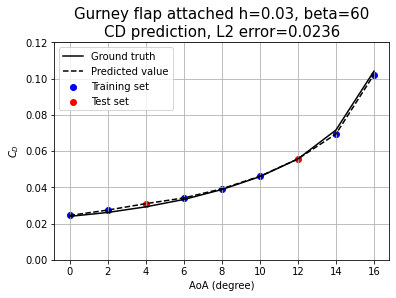

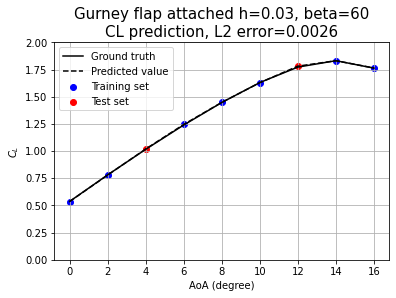

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0351, L2 error of Cl: 0.0180


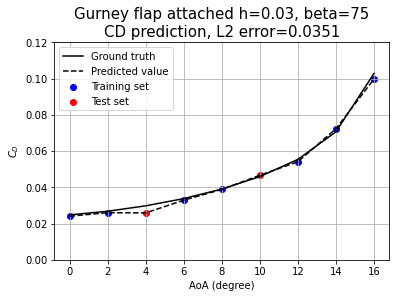

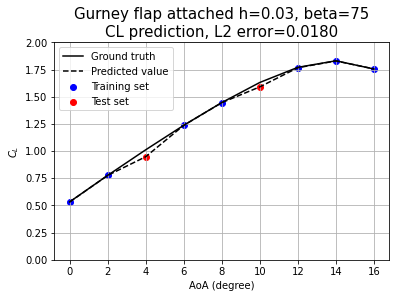

1/1 [==============================] - 0s 18ms/step
L2 error of Cd: 0.0535, L2 error of Cl: 0.0317


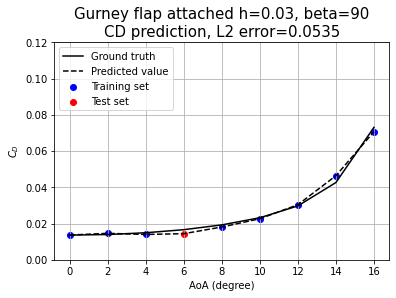

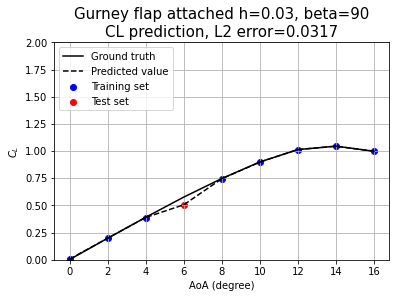

In [53]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]
for i in range(0, 16):
    iTrain = []
    iTest = []
    
    predictedValue = model.predict([x[n_alpha*i:n_alpha*(i+1),:], x_para[n_alpha*i:n_alpha*(i+1),:]])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cd = np.sqrt(np.sum((predictedValue[:,0] - y_corres[:,0])**2) / np.sum(y_corres[:,0]**2))
    l2_error_Cl = np.sqrt(np.sum((predictedValue[:,1] - y_corres[:,1])**2) / np.sum(y_corres[:,1]**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cd: {0:0.4f}, L2 error of Cl: {1:0.4f}'.format(l2_error_Cd, l2_error_Cl))
    else:
        print('L2 error of Cd: {0:0.4f}, L2 error of Cl: {1:0.4f}'.format(l2_error_Cd, l2_error_Cl))
    
    cl = predicted[n_alpha*i:n_alpha*(i+1),1]
    cd = predicted[n_alpha*i:n_alpha*(i+1),0]
    
    CL = y[n_alpha*i:n_alpha*(i+1),1]
    CD = y[n_alpha*i:n_alpha*(i+1),0]
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])

    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)
    iTest = np.array(iTest)
    
    alpha_train = []
    alpha_test = []
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)[:,0]
    aTest = np.array(alpha_test)[:,0]
    
    if i==0:
        plt.plot(alpha, CD, 'k-', label='Ground truth')
        plt.plot(alpha, cd, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,0], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,0], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_D$')
        plt.title('Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd, fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 0.12])
        plt.grid()
        savename1 = "CdComparison_NACA0018.jpg"
        plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()

        plt.plot(alpha, CL, 'k-', label='Ground truth')
        plt.plot(alpha, cl, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,1], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,1], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_L$')
        plt.title('Gurney flap not attached (NACA0018)\n$C_L$ prediction, L2 error=%.4f' % l2_error_Cl, fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 2])
        plt.grid()
        savename2 = "ClComparison_NACA0018.jpg"
        plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()
    
    else:
        plt.plot(alpha, CD, 'k-', label='Ground truth')
        plt.plot(alpha, cd, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,0], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,0], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_D$')
        plt.title('Gurney flap attached h=%.2f, beta=%d\nCD prediction, L2 error=%.4f'%(h[i], beta[i],l2_error_Cd), fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 0.12])
        plt.grid()
        savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()

        plt.plot(alpha, CL, 'k-', label='Ground truth')
        plt.plot(alpha, cl, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,1], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,1], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_L$')
        plt.title('Gurney flap attached h=%.2f, beta=%d\nCL prediction, L2 error=%.4f'%(h[i], beta[i], l2_error_Cl), fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 2])
        plt.grid()
        savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()

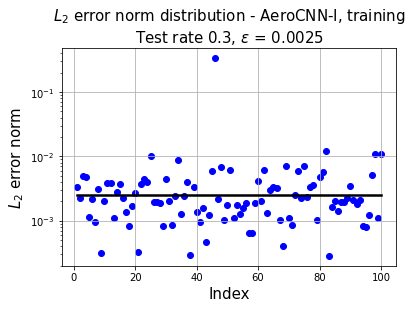

In [62]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

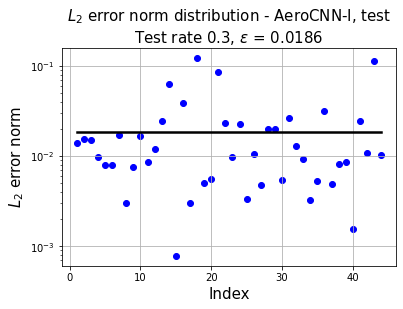

In [63]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

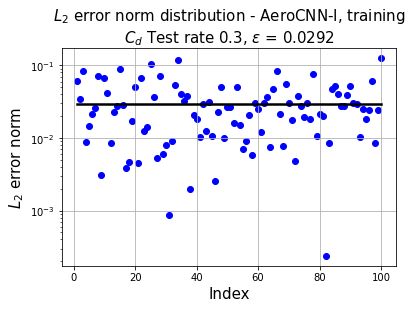

In [64]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\n$C_d$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_train), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

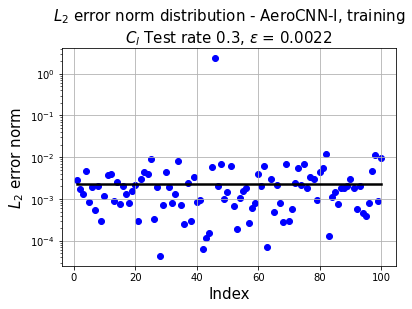

In [65]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\n$C_l$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_train), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

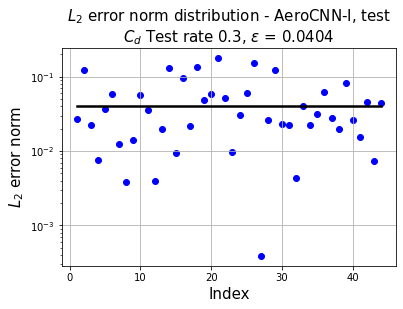

In [66]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\n$C_d$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_test), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

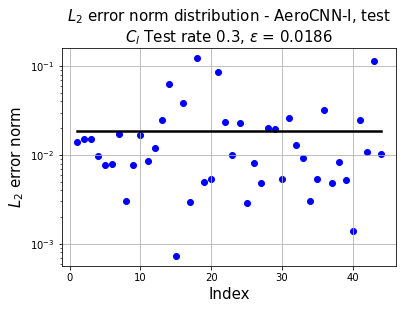

In [67]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\n$C_l$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_test), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()